this makes plots which contain the distance from the center of the tumor on the x-axis

In [1]:
import random
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid.inset_locator import inset_axes
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
from glob import glob
YELLOW = sns.xkcd_rgb["amber"]
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
CTC_SIZES = [(2,7), (8,12), (13,17), (18,22),(23,30)]

ALTERNATE_COLORS = sns.xkcd_palette(["vomit green", "orangish brown", "azure", "dark pink"])
small_c, med_c, big_c, biggest_c = ALTERNATE_COLORS

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# load data from HCC tumor

HCC = pd.read_csv('./empirical/HCtumordata.csv')
HCC = HCC.sort(columns='r')

/Users/Zaf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [3]:
import random
import json
import statsmodels.api as sm

In [4]:
# creates a color map that you can use like this: create_colormap(y) --> rgba color value
def create_colormap(colormap_name='cubehelix_r', with_yellow=False,n_colors=8, use_range=(1,3,4,6,7,7), start_bin=2, each_bin=5, return_colormap=False):
    colors = sns.color_palette(colormap_name, n_colors=n_colors)
    bin_ = start_bin
    color_mapping = {}
    for color in use_range: #map through all colors
        for i in xrange(each_bin):
            color_mapping[bin_+i] = colors[color]
        bin_= bin_ + each_bin
    
    if return_colormap:
        col_list = [ colors[i] for i in use_range]
        if with_yellow:
            col_list = [ YELLOW ] + col_list
#             col_list = [ YELLOW ] + col_list + ALTERNATE_COLORS
        return mpl.colors.ListedColormap( col_list )
    def c_mapper(i):
        print i
        try:
            if i == 1 and with_yellow:
                return YELLOW
            elif i == 100:
                return small_c
            elif i == 1000:
                return med_c
            elif i == 10000:
                return big_c
            elif i == 20000:
                return biggest_c
            else:
                return color_mapping[i]
        except Exception as e:
            print('error')
            return color_mapping[sorted(color_mapping.keys())[-1]]
    return c_mapper

In [5]:
def exponential_mean_function(x_i, y_i,k=1):
    """
        @params:
            x_i : all x_i points available
            y_i : the y_i values to average over
        @returns
            a function that can be evaluated for the mean at any point x
        
    """
    def exponential_mean_at(x):
        """
            @params:
                x: a np.array or float where the average value needs to be returned
            @returns
                <y(x)> : average value at position x
        """
        w = exp(-k*(x-x_i)**2)
        return np.dot(w, y_i) / np.sum(w)
    
    return exponential_mean_at


In [6]:
def prepare_data2(folder, yaxis='S_list_ordered', k=0.01, pts=100):
    """
        Load data from .npy files
    """
    
    
    assert yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big', 'S_list_simulated','S_list_ordered', 'D_list_ordered', 'cdrv_list_ordered', 'csnp_list_ordered'], 'yaxis is not recognized for prepare_data2'
    
    ISBIG = yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big']
    dist_file = 'dist_'+yaxis.split('_list')[1] if ISBIG else 'deltas_ordered'
    if len(glob(folder+'Dec2*/'+dist_file+'.npy')) == 0:
        raise Exception('No files found in '+folder)

    distances = np.load(glob(folder+'Dec*/'+dist_file+'.npy')[0])

    if not ISBIG:
        distances = distances[:, 0]
        
    S = np.load(glob(folder+'Dec*/'+yaxis+'.npy')[0])
    prepped = {}
    all_sizes = [1,2,3,4] if yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big'] else list([1] + CTC_SIZES)
    for ctc_size in all_sizes:
        slice_range = None
        x = None
        y = None
        color = None
        if type(ctc_size) is int: # check if this is an int so that we can handle different compared to a range...
            x = distances
            y = S[:, ctc_size-1]
            if ISBIG:
                y = y[:100]
                x = distances[:100, ctc_size-1]
            ctc_size = (ctc_size,)
        else:
            slice_range = range(ctc_size[0]-1, ctc_size[1])
            x = np.repeat(distances, ctc_size[1]-ctc_size[0]+1)
            y = S[:,slice_range].reshape(1,-1)[0]
        
        minp = 0
        maxp = distances.max() #define the maximum tumor size
        x_av = np.linspace(minp, maxp, pts)
        moving_avg_function = np.vectorize(exponential_mean_function(x,y, k = k)) # returns a function
        y_av = moving_avg_function(x_av)
        
        if ISBIG:
#             print 'idx=',ctc_size[0]
            _ctc_size = 10**(ctc_size[0]+1) if ctc_size[0] != 4 else 2*10**4
#             print 'powered=',_ctc_size
            ctc_size = (_ctc_size, ) 
        prepped[ctc_size] = [x_av, y_av]
        
    return prepped

In [7]:
def cross_sim_average(samples):
    to_be_returned = {}
    ctc_sizes = samples[0].keys()
    for ctc_size in ctc_sizes:
        to_be_avged_x = []
        to_be_avged_y = []
        # go through all samples and extract that 
        for sample in samples:
            to_be_avged_x.append(sample[ctc_size][0])
            to_be_avged_y.append(sample[ctc_size][1])

        to_be_avged_x = np.array(to_be_avged_x)
        to_be_avged_y = np.array(to_be_avged_y)
        
        x_avgd = np.mean(to_be_avged_x, axis=0)
        y_avgd = np.mean(to_be_avged_y, axis=0)
        to_be_returned[ctc_size] = [x_avgd, y_avgd]
        
    return to_be_returned
        
        

In [8]:
def data_to_plot(folder, seeds, yaxis='unique_combos', k=0.01, pts=100, mode=1, d='005'):
    samples = [] # all samples will be held here
    # first prep the data for each seed
#     print 'DATA_TO_PLOT - FOLDER:'+folder+' SEEDS:'+str(seeds)+' d:'+d

    for seed in seeds:
        this_folder = folder+'_'+d+'_outs_'+seed+'/'
#         print this_folder
        try:
            if mode == 1:
                samples.append(prepare_data1(this_folder, yaxis=yaxis, k=k, pts=pts))
            else:
                samples.append(prepare_data2(this_folder, yaxis=yaxis, k=k, pts=pts))
        except Exception as e:
            print 'data_to_plot Exception:'+str(e)
            print 'Skipped Folder:'+this_folder
#             raise e
    # produce the cross sample average
    cross_sample_averaged = cross_sim_average(samples)
    return cross_sample_averaged


In [57]:
def plot_it(cross_sample_averaged, ax, line='-'):
    colors = create_colormap(with_yellow=True)
    for ctc_size in cross_sample_averaged.keys():
        x,y = cross_sample_averaged[ctc_size]
        ax.plot(x,y, color=colors(ctc_size[0]), linestyle=line)
        
        if ctc_size[0] == 1:
            print 'mean(s(1))',np.mean(y)
            print 'std(s(1))', np.std(y)
            print 's(1)_core',np.mean(y[:10])
            print 's(1)_edge',np.mean(y[10:])

In [58]:
def plot_density(ax, folder, seeds, d='005'):
    r_samples = [] # all samples will be held here
    rho_samples = [] # all samples will be held here
    # first prep the data for each seed
#     print 'PLOT DENSITY folder:'+folder+' seeds:'+str(seeds)+' d='+d
    for seed in seeds:
        this_folder = folder+'_'+d+'_outs_'+seed+'/'
#         print this_folder
        try:
            r_samples.append(np.load(glob(this_folder+'/Dec*/r_meaned.npy')[0]))
            rho_samples.append(np.load(glob(this_folder+'/Dec*/rho2.npy')[0]))
        except Exception as e:
            print 'Exception: '+str(e)
            print 'Skipped Folder: '+this_folder
    print len(r_samples)
    print len(rho_samples)
    r = np.mean(np.array(r_samples), axis=0)
    rho = np.mean(np.array(rho_samples), axis=0)

    ax1_r = ax.twinx()
    ax1_r.fill_between(r, rho,alpha=0.09,color=(0,0,0))
    ax1_r.set_ylim([0,1.1])
    ax1_r.set_ylabel('Tumor Cell Density', rotation=-90,labelpad=15)


In [59]:
def create_colorbar(subaxes, with_yellow=False):
    cb = mpl.colorbar.ColorbarBase(subaxes, cmap=create_colormap(return_colormap=True, with_yellow=with_yellow),
    #                                 tick=['2-7', '8-13', '14-19', '20-25', '26-30'],
    #                                 extend='both',
                                    # Make the length of each extension
                                    # the same as the length of the
                                    # interior colors:
    #                                 extendfrac='auto',
    #                                 ticks=bounds,
                                    spacing='uniform',
                                    orientation='horizontal')
    cb.set_label('Cluster Sizes')
    cb.ax.get_xaxis().labelpad = 0

    ticklocs = [0.03, 0.2, 0.33, 0.5, 0.65,0.85] # location of ticks
    ticklabels = ['1', '2-7', '8-12', '13-17', '18-22', '23-30', '10^2', '10^3', '10^4', '2*10^4'] # tick labels

#     ticklocs = [0.03, 0.1, 0.21, 0.33, 0.4, 0.5, 0.65, 0.75, 0.85, 0.9] # location of ticks
#     ticklabels = ['1', '2-7', '8-12', '13-17', '18-22', '23-30', '10^2', '10^3', '10^4', '2*10^4'] # tick labels

    if not with_yellow:
        ticklabels = ticklabels[1:]
        ticklocs = list(np.linspace(0.05,0.6,4))+[0.8]

    cb.set_ticks(ticklocs)
    cb.ax.set_xticklabels(ticklabels, fontsize = 9, rotation=30)




# figure 2

In [78]:
def plot_diffs(root_folder, seeds, k=0.01, pts=100, cutoff='00'):

    fig = plt.figure(figsize=(13,3))

    ax = fig.add_subplot(131)
    folder = root_folder+'/1_0'
    d2='0'
    No_turnover = data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d2)
    Turnover = data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d='005')
    to_plot = {}
    for k in No_turnover.keys():
        avg = np.mean(k)
        to_plot[k] = [Turnover[(1,)][0], avg*(Turnover[(1,)][1]-No_turnover[(1,)][1])+No_turnover[k][1]]
    
    plot_it(to_plot, ax)
    plot_it(Turnover, ax, '--')
    ax.set_title('-: avg * (turnover - noturnover), -- turnover (d=0.05)')
    
    Turnover = data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d='01')

    ax = fig.add_subplot(132)
    to_plot = {}
    for k in No_turnover.keys():
        avg = np.mean(k)
        to_plot[k] = [Turnover[(1,)][0], avg*(Turnover[(1,)][1]-No_turnover[(1,)][1])+No_turnover[k][1]]
    
    plot_it(to_plot, ax)
    plot_it(Turnover, ax, '--')
    ax.set_title('-: avg * (turnover - noturnover), -- turnover (d=0.1)')
    

    ax = fig.add_subplot(133)
    Turnover = data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d='02')

    to_plot = {}
    for k in No_turnover.keys():
        avg = np.mean(k)
        to_plot[k] = [Turnover[(1,)][0], avg*(Turnover[(1,)][1]-No_turnover[(1,)][1])+No_turnover[k][1]]
    
    plot_it(to_plot, ax)
    plot_it(Turnover, ax, '--')
    ax.set_title('-: avg * (turnover - noturnover), -- turnover (d=0.2)')
    

2
23
18
1
mean(s(1)) 6.43942833396
std(s(1)) 2.95565829879
s(1)_core 2.27973513008
s(1)_edge 6.90161646772
8
13
2
23
18
1
mean(s(1)) 6.43942833396
std(s(1)) 2.95565829879
s(1)_core 2.27973513008
s(1)_edge 6.90161646772
8
13
2
23
18
1
mean(s(1)) 6.83907951405
std(s(1)) 2.92470641148
s(1)_core 2.43708351569
s(1)_edge 7.32819018054
8
13
2
23
18
1
mean(s(1)) 6.83907951405
std(s(1)) 2.92470641148
s(1)_core 2.43708351569
s(1)_edge 7.32819018054
8
13
2
23
18
1
mean(s(1)) 8.32013690364
std(s(1)) 2.68371136973
s(1)_core 3.99999911516
s(1)_edge 8.80015221347
8
13
2
23
18
1
mean(s(1)) 8.32013690364
std(s(1)) 2.68371136973
s(1)_core 3.99999911516
s(1)_edge 8.80015221347
8
13


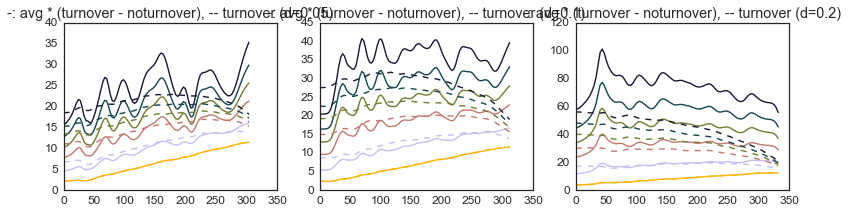

In [79]:
plot_diffs('/Volumes/Stockage/u0.03simulations/',['101','1','2','0','3','4','5','102','12151', '12152'], cutoff='00')